In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tqdm import tqdm
import random
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
#import keras
print(tf.version.VERSION)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.test.gpu_device_name()
#from tf.keras.layersConvLSTM1D
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(physical_devices)

2.2.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

train_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator=[]
for x in ['client1','client2','client3','client4','client5']:
    print(x)
    TRAINING_DIR ="./audio/image_data/FL/population_2/"+x
    train_generator.append(train_datagen.flow_from_directory(TRAINING_DIR,
                                                        batch_size=8,
                                                        class_mode='categorical',
                                                        target_size=(128, 128)))
    




print("valid set")
VALIDATION_DIR = "./audio/image_data/Test3"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=8,
                                                              class_mode='categorical',
                                                              target_size=(128, 128))
train_generator

client1
Found 439 images belonging to 4 classes.
client2
Found 434 images belonging to 4 classes.
client3
Found 434 images belonging to 4 classes.
client4
Found 434 images belonging to 4 classes.
client5
Found 434 images belonging to 4 classes.
valid set
Found 438 images belonging to 4 classes.


In [3]:

import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels


def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}



def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


class SimpleMLP:
    @staticmethod
    def build():
        

        model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
    ])        
        return model
    

def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [4]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import pickle
tf.keras.backend.clear_session()


class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            global old
            if(logs.get('val_acc') > old):
                local_model.save('FL_voice_model_'+str(client)+'.h5',overwrite=True)
                old = logs.get('val_acc')
#                 print("client=",client)
#                 print("best weight= ",old)
saver =myCallback()

comms_round = 200
    
history=[]
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build()
     
print('commence global training loop')

for comm_round in range(comms_round):
    print("comm_round=",comm_round)
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    
    #loop through each client and create new local model
    
    for client in range(5):#tqdm(range(5)):
        smlp_local = SimpleMLP()
        local_model = smlp_local.build()
        local_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])

        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        old =0
        local_model.fit_generator(train_generator[client],epochs=10,verbose=0,
                                  validation_data=validation_generator
                                  ,callbacks=[saver])
        local_model = keras.models.load_model('FL_voice_model_'+str(client)+'.h5')
        #scale the model weights and add to list
        scaling_factor = 0.2
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    global_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])
    #test global model and print out metrics after each communications round
    
    loss,acc = global_model.evaluate(validation_generator,verbose=1)
    history.append([loss,acc])
    data = pd.DataFrame(history,columns=['loss',"acc"])
    data.to_csv("FL_trials.csv")

commence global training loop
comm_round= 0
Instructions for updating:
Please use Model.fit, which supports generators.
55/55 [==============================] - 1s 26ms/step - loss: 1.3460 - acc: 0.2671
comm_round= 1
55/55 [==============================] - 1s 26ms/step - loss: 1.1058 - acc: 0.7192
comm_round= 2
55/55 [==============================] - 1s 26ms/step - loss: 1.0982 - acc: 0.7717
comm_round= 3
55/55 [==============================] - 1s 26ms/step - loss: 0.9578 - acc: 0.7854
comm_round= 4
55/55 [==============================] - 1s 26ms/step - loss: 0.9621 - acc: 0.8037
comm_round= 5
55/55 [==============================] - 1s 26ms/step - loss: 0.9410 - acc: 0.8128
comm_round= 6
55/55 [==============================] - 1s 26ms/step - loss: 0.9929 - acc: 0.8196
comm_round= 7
55/55 [==============================] - 1s 26ms/step - loss: 0.9739 - acc: 0.8151
comm_round= 8
55/55 [==============================] - 1s 26ms/step - loss: 1.1614 - acc: 0.8105
comm_round= 9
55/55 [

55/55 [==============================] - 2s 28ms/step - loss: 16.5343 - acc: 0.9155
comm_round= 162
55/55 [==============================] - 2s 28ms/step - loss: 13.5096 - acc: 0.9178
comm_round= 163
55/55 [==============================] - 2s 29ms/step - loss: 12.0670 - acc: 0.9155 0s - loss: 11.78
comm_round= 164
55/55 [==============================] - 2s 28ms/step - loss: 14.0185 - acc: 0.9155: 0s - loss: 9.2010 
comm_round= 165
55/55 [==============================] - 2s 28ms/step - loss: 12.4118 - acc: 0.9155
comm_round= 166
55/55 [==============================] - 2s 30ms/step - loss: 11.1842 - acc: 0.9178
comm_round= 167
55/55 [==============================] - 2s 29ms/step - loss: 12.3851 - acc: 0.9178
comm_round= 168
55/55 [==============================] - 2s 29ms/step - loss: 10.7442 - acc: 0.9132 0s - loss: 10.78
comm_round= 169
55/55 [==============================] - 2s 30ms/step - loss: 8.9719 - acc: 0.9178
comm_round= 170
55/55 [==============================] - 2s 29m

In [5]:
#94.34
global_model.save("FL_TRIAL_DIST.h5")

Found 438 images belonging to 4 classes.
14/14 [==============================] - 1s 102ms/step - loss: 16.4717 - acc: 0.9132
		CLASSIFICATION REPORT 

               precision    recall  f1-score   support

           0       0.98      0.95      0.96        96
           1       0.96      0.70      0.81       102
           2       0.99      1.00      0.99        90
           3       0.82      0.99      0.90       150

    accuracy                           0.91       438
   macro avg       0.94      0.91      0.92       438
weighted avg       0.92      0.91      0.91       438



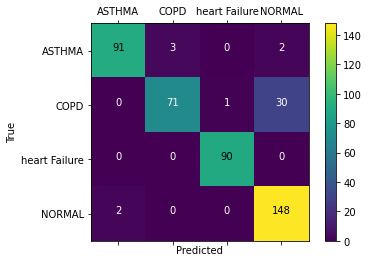

CONFUSION MATRIX
 None


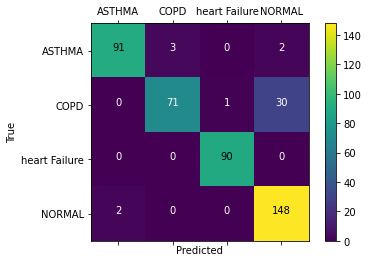

CONFUSION MATRIX
 None


In [8]:
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(128, 128),shuffle=False)
import numpy as np
from tensorflow import keras


def plot_confusion_matrix(y_true, y_pred, title='', labels=["ASTHMA","COPD","heart Failure","NORMAL"]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()
    
k =  keras.models.load_model("FL_TRIAL_DIST.h5")
L=k.predict(validation_generator,verbose=1)
k.evaluate(validation_generator,verbose=1)
classes = np.argmax(L, axis = 1)
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score


lab = validation_generator.labels
print("\t\tCLASSIFICATION REPORT \n\n",classification_report(
    lab,    
    classes
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))

In [10]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import pickle
tf.keras.backend.clear_session()


class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            global old
            if(logs.get('val_acc') > old):
                local_model.save('FL_voice_model_'+str(client)+'.h5',overwrite=True)
                old = logs.get('val_acc')
                print("client=",client)
                print("best weight= ",old)
saver =myCallback()

comms_round = 200
    
history=[]
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build()
     
print('commence global training loop')

for comm_round in range(comms_round):
    print("comm_round=",comm_round)
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    
    #loop through each client and create new local model
    
    for client in range(5):
        smlp_local = SimpleMLP()
        local_model = smlp_local.build()
        local_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])

        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        old =0
        local_model.fit_generator(train_generator[client],epochs=10,verbose=0,
                                  validation_data=validation_generator
                                 )#,callbacks=[saver])
        #local_model = keras.models.load_model('FL_voice_model_'+str(client)+'.h5')
        #scale the model weights and add to list
        scaling_factor = 0.2
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    global_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])
    #test global model and print out metrics after each communications round
    
    loss,acc = global_model.evaluate(validation_generator,verbose=1)
    history.append([loss,acc])
    data = pd.DataFrame(history,columns=['loss',"acc"])
    data.to_csv("FL_TRIAL_WITHOUT_DIST_E10.csv")

commence global training loop
comm_round= 0
14/14 [==============================] - 1s 100ms/step - loss: 1.3778 - acc: 0.2831
comm_round= 1
14/14 [==============================] - 1s 97ms/step - loss: 1.1476 - acc: 0.7397
comm_round= 2
14/14 [==============================] - 1s 102ms/step - loss: 1.2956 - acc: 0.7968
comm_round= 3
14/14 [==============================] - 2s 124ms/step - loss: 1.1483 - acc: 0.7968
comm_round= 4
14/14 [==============================] - 2s 119ms/step - loss: 1.2972 - acc: 0.8128
comm_round= 5
14/14 [==============================] - 2s 117ms/step - loss: 1.1439 - acc: 0.8311
comm_round= 6
14/14 [==============================] - 2s 115ms/step - loss: 0.9239 - acc: 0.8356
comm_round= 7
14/14 [==============================] - 2s 116ms/step - loss: 1.1232 - acc: 0.8333
comm_round= 8
14/14 [==============================] - 2s 114ms/step - loss: 1.1969 - acc: 0.8311
comm_round= 9
14/14 [==============================] - 2s 115ms/step - loss: 1.1242 - acc

KeyboardInterrupt: 

In [ ]:
#94.34
global_model.save("FL_TRIAL_WITHOUT_DISTE10.h5")

In [ ]:
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(128, 128),shuffle=False)
import numpy as np
from tensorflow import keras


def plot_confusion_matrix(y_true, y_pred, title='', labels=["ASTHMA","COPD","heart Failure","NORMAL"]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()
    
k =  keras.models.load_model("FL_TRIAL_WITHOUT_DISTE10.h5")
L=k.predict(validation_generator,verbose=1)
k.evaluate(validation_generator,verbose=1)
classes = np.argmax(L, axis = 1)
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score


lab = validation_generator.labels
print("\t\tCLASSIFICATION REPORT \n\n",classification_report(
    lab,    
    classes
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))

In [12]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import pickle
tf.keras.backend.clear_session()


class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            global old
            if(logs.get('val_acc') > old):
                local_model.save('FL_voice_model_'+str(client)+'.h5',overwrite=True)
                old = logs.get('val_acc')
                print("client=",client)
                print("best weight= ",old)
saver =myCallback()

comms_round = 200
    
history=[]
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build()
     
print('commence global training loop')

for comm_round in range(comms_round):
    print("comm_round=",comm_round)
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    
    #loop through each client and create new local model
    
    for client in range(5):
        smlp_local = SimpleMLP()
        local_model = smlp_local.build()
        local_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])

        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        old =0
        local_model.fit_generator(train_generator[client],epochs=1,verbose=0,
                                  validation_data=validation_generator
                                 )#,callbacks=[saver])
        #local_model = keras.models.load_model('FL_voice_model_'+str(client)+'.h5')
        #scale the model weights and add to list
        scaling_factor = 0.2
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    global_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])
    #test global model and print out metrics after each communications round
    
    loss,acc = global_model.evaluate(validation_generator,verbose=1)
    history.append([loss,acc])
    data = pd.DataFrame(history,columns=["loss","acc"])
    data.to_csv("FL_TRIAL_WITHOUT_DIST_E1.csv")   

commence global training loop
comm_round= 0
14/14 [==============================] - 2s 126ms/step - loss: 1.3852 - acc: 0.3425
comm_round= 1
14/14 [==============================] - 2s 167ms/step - loss: 1.2967 - acc: 0.3973
comm_round= 2
14/14 [==============================] - 2s 115ms/step - loss: 1.6093 - acc: 0.4452
comm_round= 3
14/14 [==============================] - 2s 116ms/step - loss: 1.4950 - acc: 0.5137
comm_round= 4
14/14 [==============================] - 2s 114ms/step - loss: 1.3141 - acc: 0.5913
comm_round= 5
14/14 [==============================] - 2s 117ms/step - loss: 1.3090 - acc: 0.6301
comm_round= 6
14/14 [==============================] - 2s 117ms/step - loss: 1.3524 - acc: 0.6530
comm_round= 7
14/14 [==============================] - 2s 117ms/step - loss: 1.2635 - acc: 0.6461
comm_round= 8
14/14 [==============================] - 2s 116ms/step - loss: 1.1140 - acc: 0.6553
comm_round= 9
14/14 [==============================] - 2s 115ms/step - loss: 1.1705 - ac

14/14 [==============================] - 2s 110ms/step - loss: 2.8266 - acc: 0.7123
comm_round= 165
14/14 [==============================] - 2s 108ms/step - loss: 3.5961 - acc: 0.7511
comm_round= 166
14/14 [==============================] - 1s 107ms/step - loss: 4.6394 - acc: 0.7352
comm_round= 167
14/14 [==============================] - 2s 109ms/step - loss: 4.0265 - acc: 0.7374
comm_round= 168
14/14 [==============================] - 2s 107ms/step - loss: 3.3747 - acc: 0.7489
comm_round= 169
14/14 [==============================] - 1s 104ms/step - loss: 6.0466 - acc: 0.7511
comm_round= 170
14/14 [==============================] - 2s 107ms/step - loss: 5.4637 - acc: 0.7580
comm_round= 171
14/14 [==============================] - 1s 105ms/step - loss: 3.3886 - acc: 0.7740
comm_round= 172
14/14 [==============================] - 2s 110ms/step - loss: 3.8229 - acc: 0.7443
comm_round= 173
14/14 [==============================] - 2s 107ms/step - loss: 2.5515 - acc: 0.7352
comm_round= 174


In [13]:
#94.34
global_model.save("FL_TRIAL_WITHOUT_DISTE1.h5")

Found 438 images belonging to 4 classes.
14/14 [==============================] - 1s 102ms/step - loss: 3.9624 - acc: 0.7352
		CLASSIFICATION REPORT 

               precision    recall  f1-score   support

           0       0.92      0.69      0.79        96
           1       0.92      0.48      0.63       102
           2       0.72      0.72      0.72        90
           3       0.64      0.95      0.76       150

    accuracy                           0.74       438
   macro avg       0.80      0.71      0.73       438
weighted avg       0.78      0.74      0.73       438



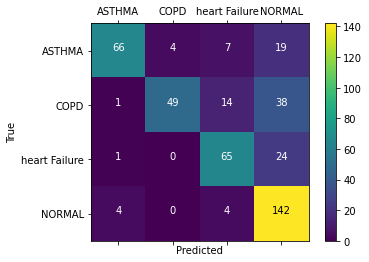

CONFUSION MATRIX
 None


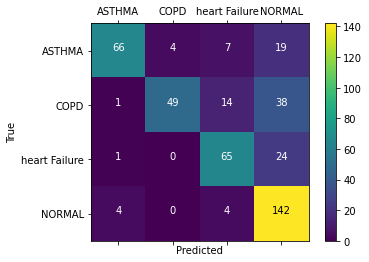

CONFUSION MATRIX
 None


In [14]:
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(128, 128),shuffle=False)
import numpy as np
from tensorflow import keras


def plot_confusion_matrix(y_true, y_pred, title='', labels=["ASTHMA","COPD","heart Failure","NORMAL"]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()
    
k =  keras.models.load_model("FL_TRIAL_WITHOUT_DISTE1.h5")
L=k.predict(validation_generator,verbose=1)
k.evaluate(validation_generator,verbose=1)
classes = np.argmax(L, axis = 1)
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score


lab = validation_generator.labels
print("\t\tCLASSIFICATION REPORT \n\n",classification_report(
    lab,    
    classes
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))

In [15]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels


def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}



def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


class SimpleMLP:
    @staticmethod
    def build():
        

        model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
    ])        
        return model
    

def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count

def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss
import math
def scale_model_weights_2(lis):
    '''function for scaling a models weights'''
    weight_final = []
    sca=[]
    lam=1.00
    for i in range(1,6):
        i=i/16
        sca.append(1/(i*3.14*((math.log(i)**2)+1)))
    m=[]
    for i in sca:
        m.append(i/sum(sca))
    sca = m
    for h,i in enumerate(lis):
        scalar_of_weight=sca[h]
        steps = len(i[0])
        temp_weights=[]
        for j in range(steps):
            temp_weights.append(scalar_of_weight * i[0][j])
        weight_final.append(temp_weights)
        
    return weight_final

In [16]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import pickle
tf.keras.backend.clear_session()
import operator



class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            global old
            if(logs.get('val_acc') > old):
                local_model.save('FL_EXP'+str(client)+'.h5',overwrite=True)
                old = logs.get('val_acc')
                #print("client=",client)
                #print("best weight= ",old)
saver =myCallback()

comms_round = 200
    
history=[]
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build()
weight_list=[]
print('commence global training loop')
count=0

smlp_local = SimpleMLP()
local_model = smlp_local.build()
local_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])
for comm_round in range(comms_round):
    print("comm_round=",comm_round)
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    
    #loop through each client and create new local model
    
    for client in range(5):
        #print(client)
        
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        old= 0
        #fit local model with client's data
        local_model.fit_generator(train_generator[client],epochs=1,verbose=0,
                                  validation_data=validation_generator
                                 )
        #local_model = keras.models.load_model('FL_voice_model_exp_'+str(client)+'.h5')
        #scale the model weights and add to list
        local_loss,local_acc = local_model.evaluate(validation_generator,verbose=0)
        if comm_round==0 :
            scaling_factor = 0.2
            scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
            scaled_local_weight_list.append(scaled_weights)
            K.clear_session()
            continue
            
        weight_list.append([local_model.get_weights(),local_acc])
        if comm_round>0:
                weight_list.sort(key = operator.itemgetter(1),reverse=True)
                scaled_local_weight_list = scale_model_weights_2(weight_list)
        
                
        
        #clear session to free memory after each communication round
        K.clear_session()
    weight_list=[]   
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    #print(scaled_local_weight_list)
    #update global model 
    global_model.set_weights(average_weights)
    
    #update global model 
    global_model.set_weights(average_weights)
    global_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])
    #test global model and print out metrics after each communications round
    
    loss,acc = global_model.evaluate(validation_generator,verbose=1)
    history.append([count,loss,acc])
    data = pd.DataFrame(history,columns=['epoch','loss',"acc"])
    data.to_csv("FL_trials_optimized_agg_2.csv")
    count+=1

commence global training loop
comm_round= 0
14/14 [==============================] - 1s 102ms/step - loss: 1.3851 - acc: 0.3425
comm_round= 1
14/14 [==============================] - 1s 104ms/step - loss: 1.3846 - acc: 0.3425
comm_round= 2
14/14 [==============================] - 1s 102ms/step - loss: 1.3195 - acc: 0.3676
comm_round= 3
14/14 [==============================] - 1s 102ms/step - loss: 1.6523 - acc: 0.3881
comm_round= 4
14/14 [==============================] - 2s 114ms/step - loss: 1.6851 - acc: 0.4452
comm_round= 5
14/14 [==============================] - 2s 115ms/step - loss: 1.7462 - acc: 0.5502
comm_round= 6
14/14 [==============================] - 2s 116ms/step - loss: 1.8651 - acc: 0.5616
comm_round= 7
14/14 [==============================] - 2s 114ms/step - loss: 1.4178 - acc: 0.6119
comm_round= 8
14/14 [==============================] - 2s 114ms/step - loss: 1.5331 - acc: 0.6484
comm_round= 9
14/14 [==============================] - 2s 115ms/step - loss: 1.3891 - ac

14/14 [==============================] - 2s 108ms/step - loss: 2.0359 - acc: 0.9064
comm_round= 165
14/14 [==============================] - 2s 109ms/step - loss: 1.7832 - acc: 0.9087
comm_round= 166
14/14 [==============================] - 1s 107ms/step - loss: 1.6510 - acc: 0.9155
comm_round= 167
14/14 [==============================] - 2s 109ms/step - loss: 2.0813 - acc: 0.9132
comm_round= 168
14/14 [==============================] - 2s 110ms/step - loss: 2.1410 - acc: 0.9132
comm_round= 169
14/14 [==============================] - 2s 107ms/step - loss: 2.7557 - acc: 0.9132
comm_round= 170
14/14 [==============================] - 2s 108ms/step - loss: 2.7434 - acc: 0.9178
comm_round= 171
14/14 [==============================] - 2s 109ms/step - loss: 2.9471 - acc: 0.9110
comm_round= 172
14/14 [==============================] - 2s 112ms/step - loss: 2.0457 - acc: 0.9155
comm_round= 173
14/14 [==============================] - 2s 108ms/step - loss: 2.3638 - acc: 0.9132
comm_round= 174


In [17]:
#94.34
global_model.save("FL_CAUCHY.h5")

Found 438 images belonging to 4 classes.
14/14 [==============================] - 2s 108ms/step - loss: 2.2846 - acc: 0.9178
		CLASSIFICATION REPORT 

               precision    recall  f1-score   support

           0       0.97      0.98      0.97        96
           1       1.00      0.71      0.83       102
           2       1.00      0.99      0.99        90
           3       0.82      0.98      0.89       150

    accuracy                           0.92       438
   macro avg       0.95      0.91      0.92       438
weighted avg       0.93      0.92      0.92       438



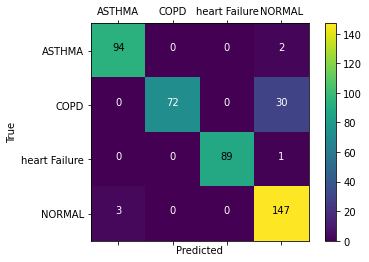

CONFUSION MATRIX
 None


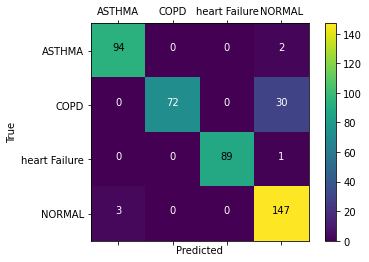

CONFUSION MATRIX
 None


In [18]:
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(128, 128),shuffle=False)
import numpy as np
from tensorflow import keras


def plot_confusion_matrix(y_true, y_pred, title='', labels=["ASTHMA","COPD","heart Failure","NORMAL"]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()
    
k =  keras.models.load_model("FL_CAUCHY.h5")
L=k.predict(validation_generator,verbose=1)
k.evaluate(validation_generator,verbose=1)
classes = np.argmax(L, axis = 1)
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score


lab = validation_generator.labels
print("\t\tCLASSIFICATION REPORT \n\n",classification_report(
    lab,    
    classes
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))

In [19]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels


def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}



def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


class SimpleMLP:
    @staticmethod
    def build():
        

        model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
    ])        
        return model
    

def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count

def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss
import math
def scale_model_weights_2(lis):
    '''function for scaling a models weights'''
    weight_final = []
    sca=[]
    lam=1.00
    for i in range(1,6):
        i=i/16
        sca.append( 1.5*np.exp(-1.5*i) )
    m=[]
    for i in sca:
        m.append(i/sum(sca))
    sca = m
    for h,i in enumerate(lis):
        scalar_of_weight=sca[h]
        steps = len(i[0])
        temp_weights=[]
        for j in range(steps):
            temp_weights.append(scalar_of_weight * i[0][j])
        weight_final.append(temp_weights)
        
    return weight_final

In [20]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import pickle
tf.keras.backend.clear_session()
import operator



class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            global old
            if(logs.get('val_acc') > old):
                local_model.save('FL_EXP'+str(client)+'.h5',overwrite=True)
                old = logs.get('val_acc')
                #print("client=",client)
                #print("best weight= ",old)
saver =myCallback()

comms_round = 200
    
history=[]
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build()
weight_list=[]
print('commence global training loop')
count=0

smlp_local = SimpleMLP()
local_model = smlp_local.build()
local_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])
for comm_round in range(comms_round):
    print("comm_round=",comm_round)
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    
    #loop through each client and create new local model
    
    for client in range(5):
        #print(client)
        
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        old= 0
        #fit local model with client's data
        local_model.fit_generator(train_generator[client],epochs=1,verbose=0,
                                  validation_data=validation_generator
                                 )
        #local_model = keras.models.load_model('FL_voice_model_exp_'+str(client)+'.h5')
        #scale the model weights and add to list
        local_loss,local_acc = local_model.evaluate(validation_generator,verbose=0)
        if comm_round==0 :
            scaling_factor = 0.2
            scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
            scaled_local_weight_list.append(scaled_weights)
            K.clear_session()
            continue
            
        weight_list.append([local_model.get_weights(),local_acc])
        if comm_round>0:
                weight_list.sort(key = operator.itemgetter(1),reverse=True)
                scaled_local_weight_list = scale_model_weights_2(weight_list)
        
                
        
        #clear session to free memory after each communication round
        K.clear_session()
    weight_list=[]   
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    #print(scaled_local_weight_list)
    #update global model 
    global_model.set_weights(average_weights)
    
    #update global model 
    global_model.set_weights(average_weights)
    global_model.compile(optimizer='nadam'  ,loss='categorical_crossentropy', metrics=['acc'])
    #test global model and print out metrics after each communications round
    
    loss,acc = global_model.evaluate(validation_generator,verbose=1)
    history.append([count,loss,acc])
    data = pd.DataFrame(history,columns=['epoch','loss',"acc"])
    data.to_csv("FL_EXP.csv")
    count+=1

commence global training loop
comm_round= 0
14/14 [==============================] - 2s 107ms/step - loss: 1.3851 - acc: 0.3425
comm_round= 1
14/14 [==============================] - 1s 107ms/step - loss: 1.3843 - acc: 0.3425
comm_round= 2
14/14 [==============================] - 2s 108ms/step - loss: 1.3837 - acc: 0.3425
comm_round= 3
14/14 [==============================] - 2s 107ms/step - loss: 1.3830 - acc: 0.3425
comm_round= 4
14/14 [==============================] - 2s 109ms/step - loss: 1.3823 - acc: 0.3425
comm_round= 5
14/14 [==============================] - 1s 107ms/step - loss: 1.3814 - acc: 0.3425
comm_round= 6
14/14 [==============================] - 2s 108ms/step - loss: 1.3802 - acc: 0.3425
comm_round= 7
14/14 [==============================] - 2s 107ms/step - loss: 1.3784 - acc: 0.3630
comm_round= 8
14/14 [==============================] - 2s 108ms/step - loss: 1.4613 - acc: 0.3699
comm_round= 9
14/14 [==============================] - 2s 107ms/step - loss: 1.6028 - ac

14/14 [==============================] - 2s 109ms/step - loss: 2.9558 - acc: 0.9064
comm_round= 165
14/14 [==============================] - 2s 109ms/step - loss: 2.6155 - acc: 0.9018
comm_round= 166
14/14 [==============================] - 2s 109ms/step - loss: 2.6659 - acc: 0.9132
comm_round= 167
14/14 [==============================] - 2s 110ms/step - loss: 3.1882 - acc: 0.9087
comm_round= 168
14/14 [==============================] - 2s 110ms/step - loss: 3.3468 - acc: 0.9087
comm_round= 169
14/14 [==============================] - 2s 109ms/step - loss: 3.5730 - acc: 0.9087
comm_round= 170
14/14 [==============================] - 2s 109ms/step - loss: 3.0429 - acc: 0.9087
comm_round= 171
14/14 [==============================] - 2s 109ms/step - loss: 2.6838 - acc: 0.9132
comm_round= 172
14/14 [==============================] - 2s 109ms/step - loss: 2.4645 - acc: 0.9064
comm_round= 173
14/14 [==============================] - 2s 109ms/step - loss: 2.9997 - acc: 0.9087
comm_round= 174


In [21]:
#94.34
global_model.save("FL_EXP.h5")

Found 438 images belonging to 4 classes.
14/14 [==============================] - 1s 107ms/step - loss: 2.7192 - acc: 0.9132
		CLASSIFICATION REPORT 

               precision    recall  f1-score   support

           0       0.99      0.96      0.97        96
           1       0.97      0.71      0.82       102
           2       1.00      0.97      0.98        90
           3       0.81      0.99      0.89       150

    accuracy                           0.91       438
   macro avg       0.94      0.91      0.92       438
weighted avg       0.93      0.91      0.91       438



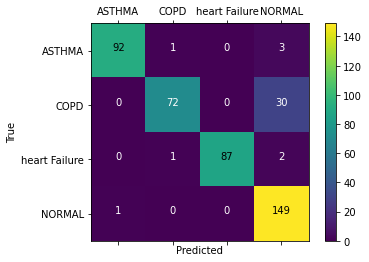

CONFUSION MATRIX
 None


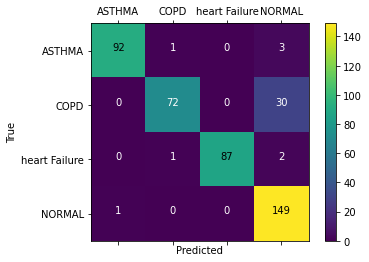

CONFUSION MATRIX
 None


In [22]:
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(128, 128),shuffle=False)
import numpy as np
from tensorflow import keras


def plot_confusion_matrix(y_true, y_pred, title='', labels=["ASTHMA","COPD","heart Failure","NORMAL"]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()
    
k =  keras.models.load_model("FL_EXP.h5")
L=k.predict(validation_generator,verbose=1)
k.evaluate(validation_generator,verbose=1)
classes = np.argmax(L, axis = 1)
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score


lab = validation_generator.labels
print("\t\tCLASSIFICATION REPORT \n\n",classification_report(
    lab,    
    classes
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))
print("CONFUSION MATRIX\n",plot_confusion_matrix(
    lab,    
    classes 
))

In [24]:

# FL_TRIAL_WITHOUT_DIST_E1
# FL_trials_optimized_agg_2#cauchy

In [4]:
import pandas as pd
EXP = pd.read_csv("FL_EXP.csv")
VAN = pd.read_csv("FL_TRIAL_WITHOUT_DIST_E1.csv")
CAUCH = pd.read_csv("FL_trials_optimized_agg_2.csv")
EXP2 = pd.read_csv("FL_EXP_2.csv")
CAUCH2 = pd.read_csv("FL_CAUCHY_2.csv")
E_15 = pd.read_csv("FL_trials.csv")

In [181]:
E_15

,Unnamed: 0,loss,acc
0,0,1.346047,0.267123
1,1,1.105783,0.719178
2,2,1.098228,0.771689
3,3,0.957795,0.785388
4,4,0.962120,0.803653
...,...,...,...
195,195,15.187946,0.915525
196,196,16.537483,0.915525
197,197,16.978718,0.915525
198,198,16.790819,0.915525


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


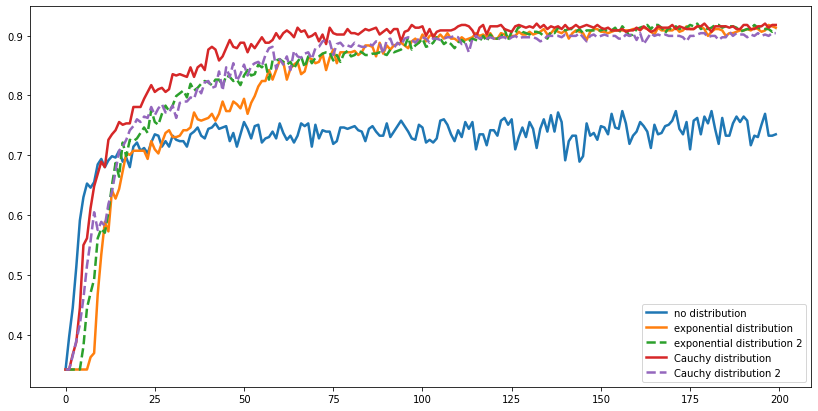

In [174]:
from scipy.interpolate import interp1d


plt.figure(figsize=(14,7))
plt.plot(VAN['acc'],label="no distribution",linewidth=2.5)
plt.plot(EXP['acc'],label="exponential distribution",linewidth=2.5)
plt.plot(EXP2['acc'], linestyle = 'dashed',label="exponential distribution 2",linewidth=2.5)
plt.plot(CAUCH['acc'],label="Cauchy distribution",linewidth=2.5)
plt.plot(CAUCH2['acc'], linestyle = 'dashed',label="Cauchy distribution 2",linewidth=2.5)
plt.legend(loc="bottom left")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


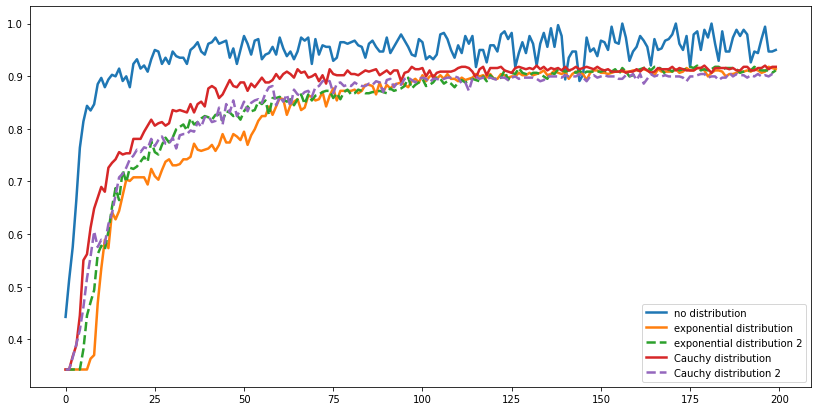

In [131]:
# plt.figure(figsize=(14,7))
# plt.plot(VAN['acc'],label="no distribution",linewidth=2.5)
# plt.plot(EXP['acc' ],label="exponential distribution",linewidth=2.5)
# plt.plot(EXP2['acc'], linestyle = 'dashed',label="exponential distribution 2",linewidth=2.5)
# plt.legend(loc="bottom left")
# plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  """


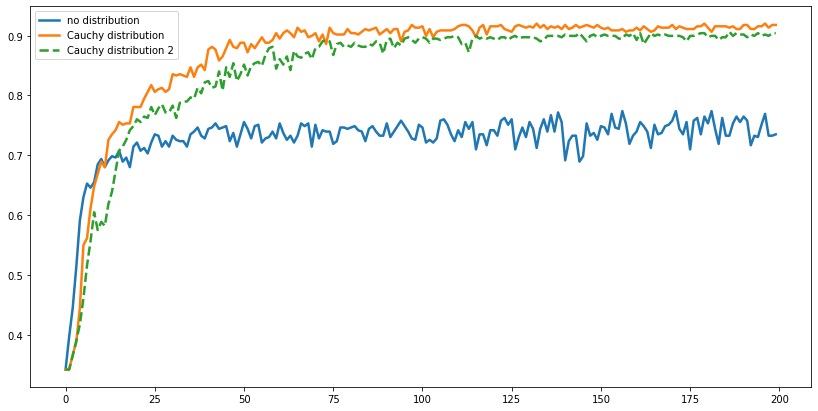

In [175]:
plt.figure(figsize=(14,7))
plt.plot(VAN['acc'],label="no distribution",linewidth=2.5)
plt.plot(CAUCH['acc'],label="Cauchy distribution",linewidth=2.5)
plt.plot(CAUCH2['acc'], linestyle = 'dashed',label="Cauchy distribution 2",linewidth=2.5)
plt.legend(loc="bottom left")
plt.show()

In [164]:
k= max(VAN['acc']),max(E_15["acc"]),max(EXP['acc']),max(EXP2['acc']),max(CAUCH['acc']),max(CAUCH2['acc'])

In [163]:
max(VAN['acc']),max(E_15["acc"]),max(EXP['acc']),max(EXP2['acc']),max(CAUCH['acc']),max(CAUCH2['acc'])

(0.7739726305007935,
 0.91780823469162,
 0.91780823469162,
 0.9200913310050964,
 0.9200913310050964,
 0.9063926935195924)

In [116]:
from scipy.interpolate import make_interp_spline
cubic_interploation_model = interp1d(x, y, kind = "cubic")
 
# Plotting the Graph
X_=np.linspace(x.min(), x.max(), 500)
Y_=cubic_interploation_model(X_)
def smooth(y):
    y= np.array(y)
    x = np.array([i for i in range(1,201)])
#     X_Y_Spline = make_interp_spline(x, y)
#     X_ = np.linspace(x.min(), x.max(),30)
#     Y_ = X_Y_Spline(X_)
    cubic_interploation_model = interp1d(x, y, kind = "cubic")

    # Plotting the Graph
    X_=np.linspace(x.min(), x.max(), 100)
    Y_=cubic_interploation_model(X_)
    return (X_,Y_)
#     plt.plot(X_,Y_,label="exponential distribution")

array([0.34246576, 0.36555861, 0.41848716, 0.51731817, 0.6050376 ,
       0.58921705, 0.62068803, 0.67641442, 0.71503885, 0.74285827,
       0.76027039, 0.7647964 , 0.78056743, 0.78063118, 0.77016549,
       0.78066691, 0.79041947, 0.79131532, 0.79739898, 0.8051173 ,
       0.82230287, 0.82194397, 0.81311187, 0.83436602, 0.82180533,
       0.84778543, 0.85220515, 0.85383406, 0.87168399, 0.87052647,
       0.85947114, 0.85839606, 0.87615897, 0.86494962, 0.86723357,
       0.88136371, 0.89187423, 0.88076417, 0.88992715, 0.88189068,
       0.88392425, 0.88207095, 0.88351081, 0.88570929, 0.87779497,
       0.89837817, 0.88236821, 0.88779919, 0.8955359 , 0.89093671,
       0.89699746, 0.89098699, 0.89337679, 0.89652954, 0.89834294,
       0.8896778 , 0.87711298, 0.90070581, 0.89633509, 0.8962512 ,
       0.89283911, 0.89826375, 0.89491852, 0.89634626, 0.89753996,
       0.89738914, 0.89159763, 0.89774987, 0.89933167, 0.89733246,
       0.90042537, 0.89901685, 0.90008434, 0.8968293 , 0.89808

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


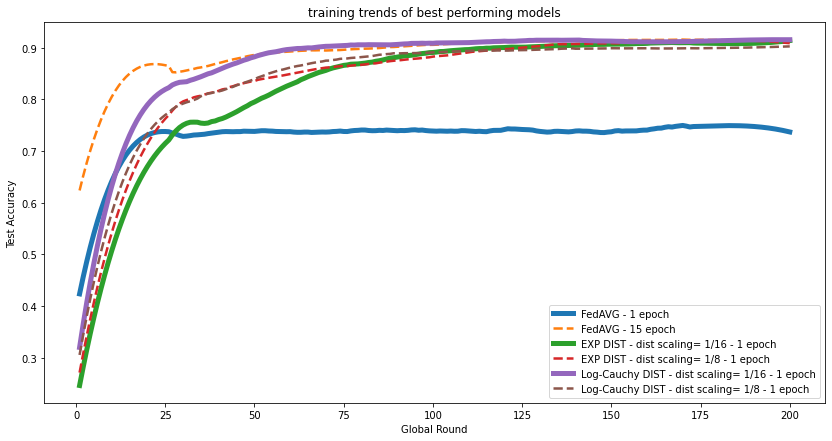

In [7]:
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
x = np.array([i for i in range(1,201)])
plt.figure(figsize=(14,7))

y = savgol_filter(VAN['acc'], 51, 3)
plt.plot(x,y,label="FedAVG - 1 epoch",linewidth =5)
y = savgol_filter(E_15['acc'], 51, 3)
plt.plot(x,y,label="FedAVG - 15 epoch",linewidth =2.5, linestyle = 'dashed')
y = savgol_filter(EXP['acc'], 51, 3)
plt.plot(x,y,label="EXP DIST - dist scaling= 1/16 - 1 epoch",linewidth =5)
y = savgol_filter(EXP2['acc'], 51, 3)
plt.plot(x,y,label="EXP DIST - dist scaling= 1/8 - 1 epoch",linewidth =2.5, linestyle = 'dashed')
y = savgol_filter(CAUCH['acc'], 51, 3)
plt.plot(x,y,label="Log-Cauchy DIST - dist scaling= 1/16 - 1 epoch",linewidth =5)
y = savgol_filter(CAUCH2['acc'], 51, 3)
plt.plot(x,y,label="Log-Cauchy DIST - dist scaling= 1/8 - 1 epoch",linewidth =2.5, linestyle = 'dashed')

plt.legend(loc="bottom left")
plt.ylabel('Test Accuracy')
plt.xlabel('Global Round')
plt.title('training trends of best performing models')
plt.savefig('FINAL_FL.eps')


plt.show()

0.5865541389693752
0.4785375269165919
0.44671902999350865
0.4359915443038768
0.4331249528792846


In [41]:
sca=[]
lam=1.00
for i in range(1,6):
    i=i/16
    sca.append(1/(i*3.14*((math.log(i)**2)+1)))
m=[]
for i in sca:
    m.append(i/sum(sca))
sca = m
sca

[0.24635534453906513,
 0.20098788753848407,
 0.18762397745513776,
 0.18311838580122713,
 0.18191440466608588]

In [42]:
'''function for scaling a models weights'''
weight_final = []
sca=[]
lam=1.00
for i in range(1,6):
    i=i/16
    sca.append( 1.5*np.exp(-1.5*i) )
m=[]
for i in sca:
    m.append(i/sum(sca))
sca = m
sca

[0.2391390023857831,
 0.21773853948234023,
 0.1982531962704264,
 0.18051158938093279,
 0.16435767248051744]

In [11]:
print(E_15["acc"])#,EXP['acc'],EXP2['acc'],CAUCH['acc'],CAUCH2['acc']

0      0.267123
1      0.719178
2      0.771689
3      0.785388
4      0.803653
         ...   
195    0.915525
196    0.915525
197    0.915525
198    0.915525
199    0.913242
Name: acc, Length: 200, dtype: float64


In [17]:
for h,i in enumerate(CAUCH["acc"]):
    print(h,i)

0 0.34246575832366943
1 0.34246575832366943
2 0.3675799071788788
3 0.388127863407135
4 0.4452054798603058
5 0.5502282977104187
6 0.5616438388824463
7 0.611872136592865
8 0.6484017968177795
9 0.6689497828483582
10 0.689497709274292
11 0.6803653240203857
12 0.7260273694992065
13 0.7351598143577576
14 0.7420091032981873
15 0.7557077407836914
16 0.7511415481567383
17 0.7534246444702148
18 0.7534246444702148
19 0.7808219194412231
20 0.7808219194412231
21 0.7808219194412231
22 0.7945205569267273
23 0.8059360980987549
24 0.8173515796661377
25 0.8059360980987549
26 0.810502290725708
27 0.8127853870391846
28 0.8059360980987549
29 0.810502290725708
30 0.835616409778595
31 0.8333333134651184
32 0.835616409778595
33 0.8333333134651184
34 0.8310502171516418
35 0.8470319509506226
36 0.8310502171516418
37 0.8470319509506226
38 0.8515982031822205
39 0.8424657583236694
40 0.8767123222351074
41 0.8812785148620605
42 0.8767123222351074
43 0.8584474921226501
44 0.8652967810630798
45 0.8789954185485841
46 

In [25]:
import tensorflow as tf
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
# #tf.keras.layers.BatchNormalization(),
# tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
# tf.keras.layers.MaxPooling2D(2, 2),
# tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
# tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
# tf.keras.layers.MaxPooling2D(2, 2),
# tf.keras.layers.Flatten(),
# tf.keras.layers.Dense(64, activation='relu'),
# tf.keras.layers.Dropout(0.5),
# tf.keras.layers.Dense(32, activation='relu'),
# tf.keras.layers.Dense(4, activation='softmax')
# ]) 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(20, input_shape=(784,10,)))
model.add(tf.keras.layers.Activation("relu"))
#         model.add(Dense(20))#,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5)))

#         model.add(Activation("relu"))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation("softmax"))
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 784, 20)           220       
_________________________________________________________________
activation_3 (Activation)    (None, 784, 20)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 784, 10)           210       
_________________________________________________________________
activation_4 (Activation)    (None, 784, 10)           0         
Total params: 430
Trainable params: 430
Non-trainable params: 0
_________________________________________________________________


In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
GENERATE_RES = 4 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16
idk ="Normal"
# Size vector to generate images from
SEED_SIZE = 1000

# Configuration
DATA_PATH = './audio/image_data/'+idk
EPOCHS = 2000
BATCH_SIZE = 32
channels = 3
BUFFER_SIZE = 60000
print(f"Will generate {GENERATE_SQUARE}px square images.")
model = Sequential()

model.add(Dense(4*4*256,activation="relu",input_dim=1000)),
model.add(Reshape((4,4,256)))

model.add(UpSampling2D())
model.add(Conv2D(256,kernel_size=3,padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(Activation("relu"))

model.add(UpSampling2D())
model.add(Conv2D(256,kernel_size=3,padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(Activation("relu"))

# Output resolution, additional upsampling
model.add(UpSampling2D())
model.add(Conv2D(128,kernel_size=3,padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(Activation("relu"))

model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
model.add(Conv2D(128,kernel_size=3,padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(Activation("relu"))

# Final CNN layer
model.add(Conv2D(channels,kernel_size=3,padding="same"))
model.add(Activation("tanh"))
model._name = "Generator"
model.summary()

Will generate 128px square images.
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 4096)              4100096   
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_17 (Activation)   (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_12 (UpSa

In [38]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=[120,120,3], 
                 padding="same"))
model.add(LeakyReLU(alpha=0.2))

model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
model.add(ZeroPadding2D(padding=((0,1),(0,1))))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(alpha=0.2))

model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(alpha=0.2))

model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(alpha=0.2))

model.add(Dropout(0.25))
model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(alpha=0.2))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model._name = "Discriminator"
model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 60, 60, 32)        896       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 31, 31, 64)      